In [1]:
# https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
# https://colab.research.google.com/github/rpi-techfundamentals/website_spring_2020/blob/master/content/notebooks/20-deep-learning1/06-regression-bh-pytorch.ipynb#scrollTo=xD9PhAU7hoqT
#!pip install torchvision
import numpy as np
import pandas as pd
import pyreadr
import scipy
#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable
high_var = ['rain_30', 'rain_60','rain_90', 't_max_30', 't_max_60', 't_max_90', 't_min_30', 't_min_60', 't_min_90', 'Y_prev',
 'Y_corn_lt_avg', 'day_sow', 'day_v5', 'lai_v5', 'whc', 'oc_20cm_v5', 'sw_dep_v5', 'n_0_60cm_v5', 'surfaceom_wt_v5', 'sand_40cm', 'clay_40cm']


In [2]:
# check pytorch version
import torch
print(torch.__version__)

1.4.0


In [3]:
class Net(torch.nn.Module):
    def __init__(self, cols):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(cols, 50)   # hidden layer
        self.hidden2 = torch.nn.Linear(50, 10)   # hidden layer
        #self.hidden3 = torch.nn.Linear(100, 50)   # hidden layer
        self.predict = torch.nn.Linear(10, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))      # activation function for hidden layer
        #x = F.relu(self.hidden3(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [4]:
def build_cnn(TrainSet_eonr_scaled, policy):
    #Define training hyperprameters.
    batch_size = 50
    num_epochs = 100
    learning_rate = 0.01
    
    y_train = TrainSet_eonr_scaled['eonr']
    X_train = TrainSet_eonr_scaled.drop('eonr', axis=1)

    X_train=X_train.values
    y_train=y_train.values

    #Calculate some other hyperparameters based on data.  
    batch_no = len(X_train) // batch_size  #batches
    cols=X_train.shape[1] #Number of columns in input matrix

    #Create the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Assume that we are on a CUDA machine, then this should print a CUDA device:
    print("Executing the model on :",device)

    net = Net(cols)
    #Adam is a specific flavor of gradient decent which is typically better
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
    criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss

    running_loss = 0.0
    for epoch in range(num_epochs):
        #Shuffle just mixes up the dataset between epocs
        X_train, y_train = shuffle(X_train, y_train)
        # Mini batch learning
        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            inputs = Variable(torch.FloatTensor(X_train[start:end]))
            labels = Variable(torch.FloatTensor(y_train[start:end]))
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            outputs = net(inputs)
            # calculate loss
            loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        #print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
        running_loss = 0.0
    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    torch.save(net.state_dict(), path)
    return(net)
        

In [5]:
#Build one cnn using the function
TrainSet_eonr2_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/TrainSet_eonr2.rds")[None] # also works for RData
TrainSet_eonr2_df = TrainSet_eonr2_df[high_var+['eonr']]
net_return = build_cnn(TrainSet_eonr2_df, 'ratio_5')

Executing the model on : cuda:0


/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [6]:
# #Make predictions with returned model
# prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

# X_pred = prediction_set_aggregated_df[['rain_30', 'rain_60','rain_90', 't_max_30', 't_max_60', 't_max_90', 't_min_30', 't_min_60', 't_min_90', 'Y_prev',
#  'Y_corn_lt_avg', 'day_sow', 'day_v5', 'lai_v5', 'whc', 'oc_20cm_v5', 'sw_dep_v5', 'n_0_60cm_v5', 'surfaceom_wt_v5', 'sand_40cm', 'clay_40cm']]

# X_pred=X_pred.values

# X = Variable(torch.FloatTensor(X_pred)) 
# y_pred = net_return(X) #This outputs the value for regression
# y_pred=y_pred.data[:,0].numpy()
# y_pred
# prediction_set_aggregated_df['eonr_pred'] = y_pred

# # now let's write a Rds
# pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
# prediction_set_aggregated_df.head()

In [7]:
#Load the saved model
policy = 'ratio_5'
path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
net_load = Net(21)
net_load.load_state_dict(torch.load(path))
net_load.eval()

Net(
  (hidden1): Linear(in_features=21, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
#Make predictions with the saved model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X_pred = prediction_set_aggregated_df[high_var]

X_pred=X_pred.values
X_pred
X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net_load(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred
prediction_set_aggregated_df['eonr_pred'] = y_pred

# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
prediction_set_aggregated_df.head()

,id_10,id_field,region,z,eonr_12,rain_30,rain_60,rain_90,t_max_30,t_max_60,...,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm,area_ha,eonr_pred
0,5,3.0,3.0,11,200.0,125.0,229.0,17.0,22.050000,15.216667,...,0.408,294.075688,1.620588,629.483784,35.048204,465.378891,5.071375,21.024234,40.0,127.891525
1,5,3.0,3.0,13,200.0,140.0,108.0,19.0,22.133333,15.933333,...,0.402,294.075688,1.625338,666.127141,42.310082,511.010443,5.071375,21.024234,40.0,135.954254
2,5,3.0,3.0,15,240.0,96.0,101.0,39.0,20.666667,16.783333,...,0.406,294.075688,1.622531,620.573678,46.126236,497.375201,5.071375,21.024234,40.0,152.061966
3,5,3.0,3.0,17,160.0,96.0,47.0,33.0,22.016667,17.066667,...,0.397,294.075688,1.620151,629.544435,70.271481,462.792524,5.071375,21.024234,40.0,103.177956
4,5,3.0,3.0,19,200.0,43.0,183.0,51.0,23.916667,12.283333,...,0.398,294.075688,1.623718,623.843297,47.598318,721.119533,5.071375,21.024234,40.0,167.331940


In [9]:
from sklearn.metrics import mean_squared_error

print(prediction_set_aggregated_df['eonr_pred'].min(),
prediction_set_aggregated_df['eonr_pred'].max(),
prediction_set_aggregated_df['eonr_pred'].mean(),
mean_squared_error(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred']))

50.479976654052734 392.2103271484375 147.8922576904297 3666.442820923359


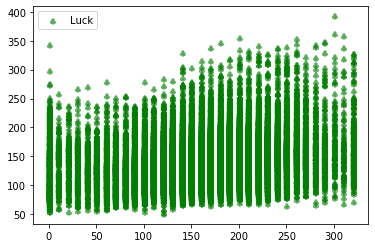

In [10]:
# 3228 3152 2966 3292 3184 3192 3254 2993
import matplotlib.pyplot as plt
import numpy as np

x = prediction_set_aggregated_df['eonr_12']
y = prediction_set_aggregated_df['eonr_pred']

plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")
plt.legend(loc='upper left')
plt.show()

In [11]:
# Make a function that loads the saved model and does predictions

prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None]


In [12]:
def predict_cnn(prediction_set_aggregated_df, policy):
    #Load the saved model
    #policy = 'ratio_5'
    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    net_load = Net(21)
    net_load.load_state_dict(torch.load(path))
    net_load.eval()
    net_load.state_dict()
    X_pred = prediction_set_aggregated_df[high_var]
    X_pred=X_pred.values
    X_pred
    X = Variable(torch.FloatTensor(X_pred)) 
    y_pred = net_load(X) #This outputs the value for regression
    y_pred=y_pred.data[:,0].numpy()
    y_pred
    prediction_set_aggregated_df['eonr_pred'] = y_pred
    return(prediction_set_aggregated_df)


In [13]:
# Use the function
prediction_set_aggregated_df2 = predict_cnn(prediction_set_aggregated_df, 'ratio_5')
prediction_set_aggregated_df2

,id_10,id_field,region,z,eonr_12,rain_30,rain_60,rain_90,t_max_30,t_max_60,...,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm,area_ha,eonr_pred
0,5,3.0,3.0,11,200.0,125.0,229.0,17.0,22.050000,15.216667,...,0.408,294.075688,1.620588,629.483784,35.048204,465.378891,5.071375,21.024234,40.0,127.891525
1,5,3.0,3.0,13,200.0,140.0,108.0,19.0,22.133333,15.933333,...,0.402,294.075688,1.625338,666.127141,42.310082,511.010443,5.071375,21.024234,40.0,135.954254
2,5,3.0,3.0,15,240.0,96.0,101.0,39.0,20.666667,16.783333,...,0.406,294.075688,1.622531,620.573678,46.126236,497.375201,5.071375,21.024234,40.0,152.061966
3,5,3.0,3.0,17,160.0,96.0,47.0,33.0,22.016667,17.066667,...,0.397,294.075688,1.620151,629.544435,70.271481,462.792524,5.071375,21.024234,40.0,103.177956
4,5,3.0,3.0,19,200.0,43.0,183.0,51.0,23.916667,12.283333,...,0.398,294.075688,1.623718,623.843297,47.598318,721.119533,5.071375,21.024234,40.0,167.331940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60362,1526,1.0,1.0,29,200.0,251.0,117.0,53.0,23.083333,15.950000,...,0.332,283.620092,1.141886,709.097091,42.566269,207.000000,20.469739,19.590676,40.0,185.867981
60363,1526,1.0,1.0,3,290.0,138.0,79.0,107.0,22.150000,17.666667,...,0.314,283.620092,1.140929,654.037549,29.381942,143.842076,20.469739,19.590676,40.0,286.058838
60364,1526,1.0,1.0,5,240.0,141.0,124.0,120.0,21.766667,12.533333,...,0.289,283.620092,1.141471,664.828798,27.620442,211.432364,20.469739,19.590676,40.0,177.268677
60365,1526,1.0,1.0,7,260.0,190.0,16.0,132.0,21.750000,20.883333,...,0.320,283.620092,1.137555,670.810914,28.431346,94.554173,20.469739,19.590676,40.0,353.056885
